In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 60
periods = 20
threshold = 1.0
multiplier = 50
bankroll = 15000

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20180202':]
#contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2018-02-02 04:02:00,2826.50,2831.00,2811.75,2817.50,13141,63333
1,2018-02-02 09:59:00,2817.25,2821.25,2807.75,2808.75,14544,62759
2,2018-02-02 11:17:00,2808.75,2810.25,2797.00,2800.50,13327,64130
3,2018-02-02 13:43:00,2800.50,2806.00,2799.00,2806.00,12870,65988
4,2018-02-02 14:40:00,2805.75,2807.25,2799.50,2802.50,11061,63423
...,...,...,...,...,...,...,...
9065,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743
9066,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663
9067,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                    'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
#data.set_index('date', inplace=True)

In [7]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()
data['breakout_norm_mean'] = data['breakout_norm'].ewm(span=periods).mean()

In [8]:
#backtest(data.open.iloc[200:].copy(), data.breakout_norm.iloc[200:].copy(), 1, 20, 50000)

In [9]:
test = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': data.close,
                    'breakout_norm': data.breakout_norm_mean})
test = test.iloc[periods*3:]
test.set_index('date', inplace=True)
test['long'] = (test['breakout_norm'] > threshold) * 1
test['short'] = (test['breakout_norm'] < -threshold) * -1
test['signal'] = (test.long + test.short).shift(1)
test['signal'] = test['signal'].fillna(0)
test['position'] = test['signal'] * test['open']
test['base'] = (test['signal'] - test['signal'].shift(1)) * test.open
test['base'] = test['base'] + test['open'].shift(1) * test['signal'].shift(1)
test['base'] = test['base'].fillna(0)
test['pnl'] = test['position'] - test['base']

In [10]:
test.pnl.sum()

399.25

In [11]:
test.pnl.sum() * multiplier

19962.5

In [17]:
test.head(50)

,open,close,breakout_norm,long,short,signal,position,base,pnl,pnl_dollars,cum_pnl_dollars,balance
date,,,,,,,,,,,,
2018-02-05 19:14:00,2728.75,2725.25,-0.967722,0,0,0.0,0.00,0.00,0.00,0.0,0.0,15000.0
2018-02-05 19:24:00,2725.50,2722.00,-1.067668,0,-1,0.0,0.00,0.00,0.00,0.0,0.0,15000.0
2018-02-05 19:33:00,2722.00,2722.25,-1.150699,0,-1,-1.0,-2722.00,-2722.00,0.00,0.0,0.0,15000.0
2018-02-05 19:44:00,2722.50,2718.50,-1.233942,0,-1,-1.0,-2722.50,-2722.00,-0.50,-25.0,-25.0,14975.0
2018-02-05 19:57:00,2718.50,2727.25,-1.227280,0,-1,-1.0,-2718.50,-2722.50,4.00,200.0,175.0,15175.0
2018-02-05 20:09:00,2727.25,2722.00,-1.266318,0,-1,-1.0,-2727.25,-2718.50,-8.75,-437.5,-262.5,14737.5
2018-02-05 20:21:00,2722.25,2716.50,-1.332440,0,-1,-1.0,-2722.25,-2727.25,5.00,250.0,-12.5,14987.5
2018-02-05 20:30:00,2716.25,2709.25,-1.413867,0,-1,-1.0,-2716.25,-2722.25,6.00,300.0,287.5,15287.5
2018-02-05 20:38:00,2709.25,2707.00,-1.498239,0,-1,-1.0,-2709.25,-2716.25,7.00,350.0,637.5,15637.5


In [13]:
test['pnl_dollars'] = test['pnl'] * multiplier
test['cum_pnl_dollars'] = test['pnl_dollars'].cumsum()
test['balance'] = bankroll + test['cum_pnl_dollars']

In [14]:
transactions = test[test.signal != test.signal.shift(-1)][['signal', 'cum_pnl_dollars']]
transactions.merge(test[test.signal != test.signal.shift(1)][['signal', 'cum_pnl_dollars']], how='outer')
transactions.reset_index(inplace=True)
positions = transactions[transactions.index % 2 == 0]
last_row = transactions[transactions.index % 2 != 0].iloc[-1]
if last_row.date != positions.date.iloc[-1]:
    positions = positions.append(last_row)
positions['transaction_pnl'] = positions['cum_pnl_dollars'].diff()
positions = positions.iloc[1:]
positions.set_index('date', inplace=True)

In [18]:
transactions.head(10)

,date,signal,cum_pnl_dollars
0,2018-02-05 19:24:00,0.0,0.0
1,2018-02-06 12:57:00,-1.0,5687.5
2,2018-02-06 16:05:00,0.0,6975.0
3,2018-02-06 16:28:00,1.0,5137.5
4,2018-02-06 22:03:00,0.0,5012.5
5,2018-02-07 11:51:00,1.0,3500.0
6,2018-02-07 13:55:00,0.0,3762.5
7,2018-02-07 20:13:00,1.0,4475.0
8,2018-02-08 17:09:00,0.0,4500.0
9,2018-02-09 15:52:00,-1.0,6887.5


In [16]:
positions

,signal,cum_pnl_dollars,transaction_pnl
date,,,
2018-02-06 16:05:00,0.0,6975.0,6975.0
2018-02-06 22:03:00,0.0,5012.5,-1962.5
2018-02-07 13:55:00,0.0,3762.5,-1250.0
2018-02-08 17:09:00,0.0,4500.0,737.5
2018-02-09 18:19:00,0.0,6700.0,2200.0
...,...,...,...
2019-08-28 15:43:00,0.0,18537.5,-762.5
2019-08-29 11:44:00,0.0,18000.0,-537.5
2019-09-03 12:25:00,0.0,18437.5,437.5


In [15]:
positions['transaction_pnl'].sum()

19962.5

In [163]:
winning_positions = positions[positions.transaction_pnl > 0]
losing_positions = positions[positions.transaction_pnl < 0]
winning_percent = len(winning_positions) / (len(winning_positions) + len(losing_positions))
avg_gain = winning_positions.transaction_pnl.sum() / len(winning_positions)
avg_loss = losing_positions.transaction_pnl.sum() / len(losing_positions)
ratio = abs(avg_gain / avg_loss)
ev = (winning_percent * avg_gain) + ((1 - winning_percent) * avg_loss)
winning_percent, avg_gain, avg_loss, ratio, ev

(0.3829787234042553,
 1259.548611111111,
 -609.698275862069,
 2.065855622324339,
 106.18351063829789)

In [164]:
len(transactions)

378

In [166]:
daily = test.balance.resample('B').last().fillna(method='ffill')
daily[daily.index[0]-pd.Timedelta(days=1)] = bankroll
daily.sort_index(inplace=True)
daily = pd.DataFrame({'balance': daily})
daily['returns'] = daily.balance.pct_change()
daily = daily.iloc[1:]

In [167]:
perf_stats(daily['returns'])

Annual return           0.673796
Cumulative returns      1.330833
Annual volatility       0.530846
Sharpe ratio            1.219217
Calmar ratio            2.473362
Stability               0.611846
Max drawdown           -0.272421
Omega ratio             1.319814
Sortino ratio           2.513923
Skew                    3.349488
Kurtosis               26.385175
Tail ratio              1.310410
Daily value at risk    -0.064312
dtype: float64

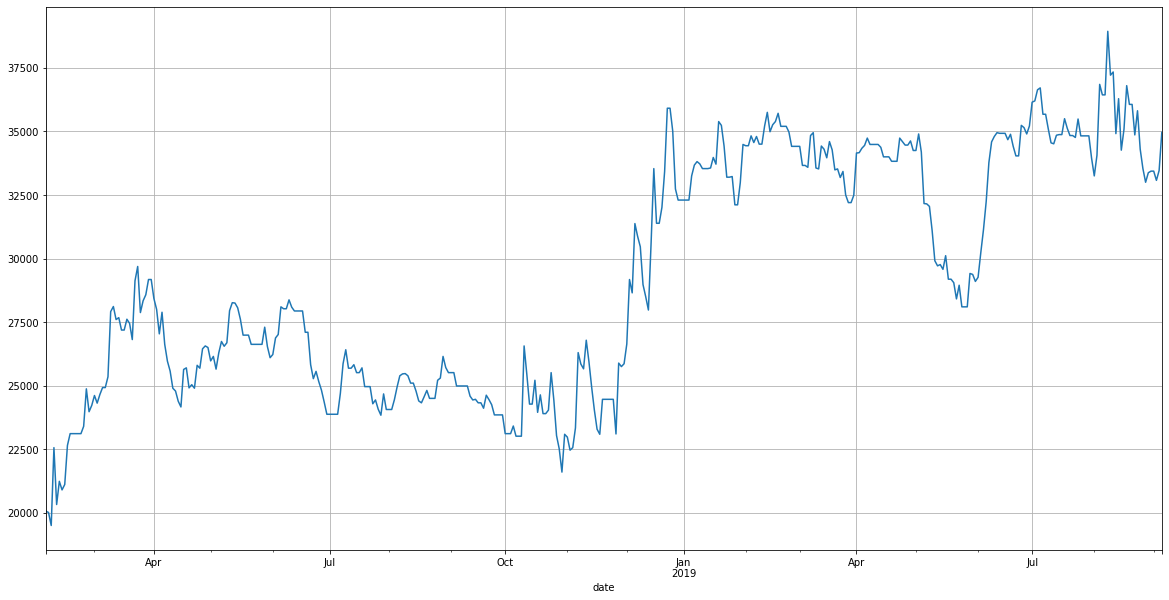

In [25]:
daily.balance.plot(figsize=(20,10), grid=True);

In [26]:
trades = test[test.signal != test.signal.shift()].signal.count()
days = daily.returns.count()
trades/days

0.9130434782608695

In [27]:
days

414